In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sipm.sipm as sipm
import sipm.dataset as ds

In [3]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
voltages = ['20220923_60V_laser_3725thres','20220923_61V_laser_3722thres','20220923_62V_laser_3722thres','20220923_63V_laser_3720thres','20220923_64V_laser_3718thres']

In [5]:
path = "/home/aj9512/jadwin-365/data/sipm/{}/"

In [6]:
channels = [0,1,2,3]
channels = [0]

In [7]:
for volt in voltages[-1:]:
    data = ds.Dataset(path.format(volt), pol=-1, channels=channels)
    print(data.ch[0].file)
    for i in channels:
        print("Analyzing channel {}".format(i))
        data.ch[i].read_data()
        data.ch[i].bandpass_filter(low=10, high=8e6, order=3)
        data.ch[i].baseline_subtraction()
        data.ch[i].get_max()
        data.ch[i].get_integral()
        data.ch[i].clear()

/home/aj9512/jadwin-365/data/sipm/20220923_64V_laser_3718thres/wave0.dat
Analyzing channel 0


In [8]:
# index = 20410
# plt.figure()
# plt.xlim(-1,10)
# plt.plot(data.ch[0].time, data.ch[0].traces[index])
# plt.vlines(x=data.ch[0].time[500], ymin=-2, ymax=8, color='r', lw=1)
# plt.vlines(x=data.ch[0].time[data.ch[0].peak_pos[index]-50], ymin=-2, ymax=8, color='r', lw=1)
# plt.vlines(x=data.ch[0].time[data.ch[0].peak_pos[index]+650], ymin=-2, ymax=8, color='r', lw=1)
# plt.show()
# print(np.sum(data.ch[0].traces[index][data.ch[0].peak_pos[index]-80:data.ch[0].peak_pos[index]+600]))

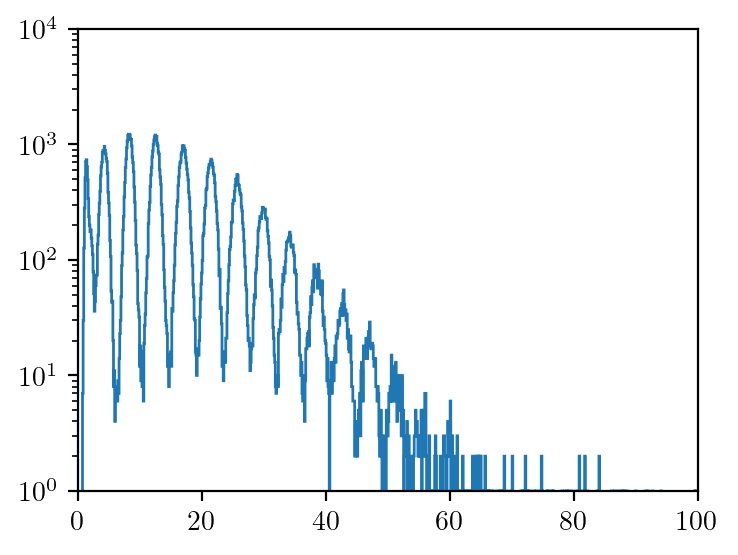

In [9]:
plt.figure()
for i in channels:
    plt.hist(data.ch[i].peak, bins=np.arange(0,100,0.1), histtype='step')
plt.yscale('log')
plt.show()

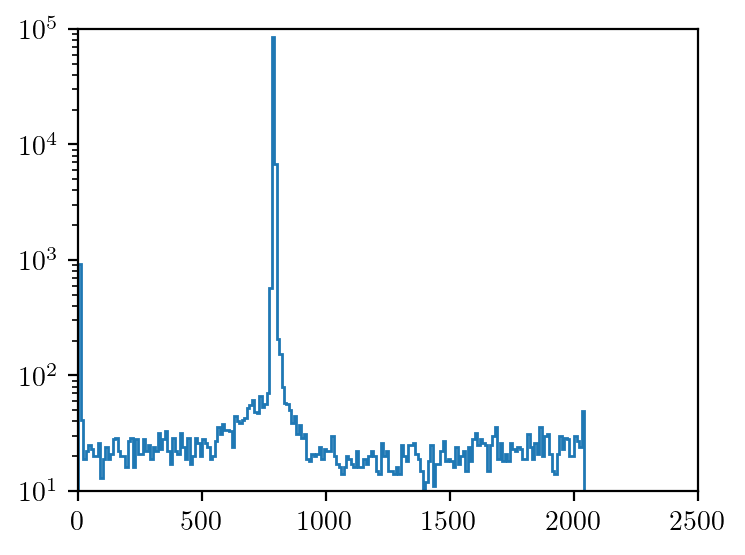

In [10]:
plt.figure()
for i in channels:
    plt.hist(data.ch[i].peak_pos, bins=np.arange(0,2048,10), histtype='step')
plt.yscale('log')
plt.show()

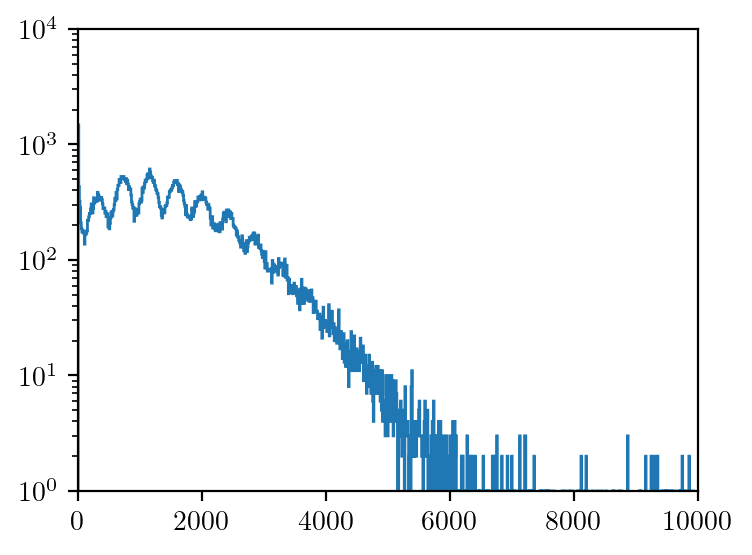

In [13]:
plt.figure()
for i in channels:
    plt.hist(data.ch[i].integral, bins=np.arange(0,10000,10), histtype='step')
plt.yscale('log')
plt.show()